In [1]:
import pandas as pd
import numpy as np
import pickle
import warnings

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from prophet import Prophet


warnings.filterwarnings("ignore")

c:\Users\nycol\OneDrive\Documentos\0 Pos Tech\Fase 4\Tech Challenge\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_ipea = pd.read_csv('./data/df_ipea.csv')
df_ipea['Data'] = pd.to_datetime(df_ipea['Data'], format='%Y-%m-%d')
df_ipea.head()

,Data,Preço - petróleo bruto - Brent (FOB)
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [21]:
from datetime import datetime
today = datetime.now()
today

datetime.datetime(2024, 5, 20, 22, 35, 26, 618400)

In [25]:
l = df_ipea.iloc[-1:,0].iloc[0]
type(l)

pandas._libs.tslibs.timestamps.Timestamp

### Avaliando a série

In [16]:
df_decompose = df_ipea.query("Data.dt.year >= 2014")
df_decompose = df_decompose.rename(columns={'Data':'DATE', 'Preço - petróleo bruto - Brent (FOB)':'Price'})
df_decompose.set_index('DATE', inplace=True)
df_decompose.head()

,Price
DATE,
2014-01-02,107.94
2014-01-03,110.47
2014-01-04,109.95
2014-01-06,107.94
2014-01-07,106.57


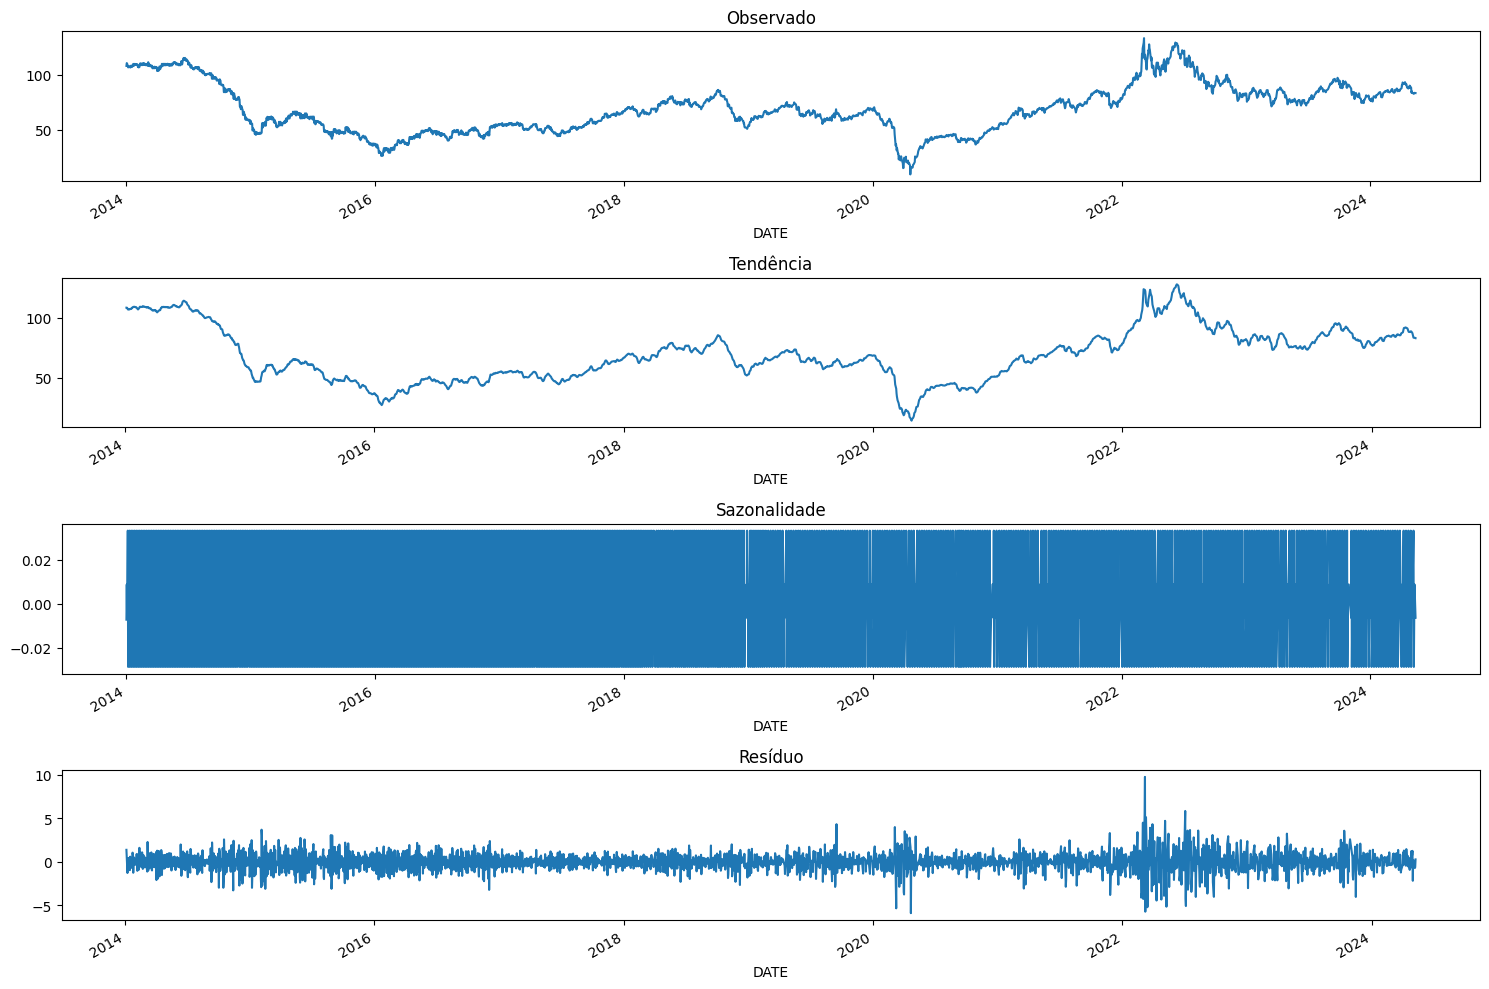

In [17]:
decompose = seasonal_decompose(df_decompose['Price'], model='aditive', period=5)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

decompose.observed.plot(ax=ax1,title='Observado')
decompose.trend.plot(ax=ax2, title='Tendência')
decompose.seasonal.plot(ax=ax3, title='Sazonalidade')
decompose.resid.plot(ax=ax4, title='Resíduo')

plt.tight_layout()

In [18]:
# 2014, period=5
X = df_decompose['Price'].values
teste_ad = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico: {teste_ad[0]}")
print(f"P-Value: {teste_ad[1]}")
print("Valores críticos:")

for key, value in teste_ad[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -2.4991538494439025
P-Value: 0.1156803380927317
Valores críticos:
	1%: -3.43244429748926
	5%: -2.862465330873631
	10%: -2.5672625756416


### Treinando modelos

In [3]:
def wmape(y_true, y_pred):
  return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

In [4]:
df_modelos = df_ipea.rename(columns={'Data':'ds','Preço - petróleo bruto - Brent (FOB)':'y'})
df_modelos['unique_id'] = 'Petroleo Brent (FOB)'

In [5]:
treino_full = df_modelos.iloc[:-5,:]
teste = df_modelos.iloc[-5:,:]
h = teste.shape[0]
treino_full

,ds,y,unique_id
0,1987-05-20,18.63,Petroleo Brent (FOB)
1,1987-05-21,18.45,Petroleo Brent (FOB)
2,1987-05-22,18.55,Petroleo Brent (FOB)
3,1987-05-25,18.60,Petroleo Brent (FOB)
4,1987-05-26,18.63,Petroleo Brent (FOB)
...,...,...,...
11159,2024-04-29,88.44,Petroleo Brent (FOB)
11160,2024-04-30,88.23,Petroleo Brent (FOB)
11161,2024-05-01,83.55,Petroleo Brent (FOB)
11162,2024-05-02,84.81,Petroleo Brent (FOB)


In [22]:
treino_2014 = treino_full.query('ds.dt.year>=2014')
treino_2014

,ds,y,unique_id
8026,2014-01-02,107.94,Petroleo Brent (FOB)
8027,2014-01-03,110.47,Petroleo Brent (FOB)
8028,2014-01-04,109.95,Petroleo Brent (FOB)
8029,2014-01-06,107.94,Petroleo Brent (FOB)
8030,2014-01-07,106.57,Petroleo Brent (FOB)
...,...,...,...
11159,2024-04-29,88.44,Petroleo Brent (FOB)
11160,2024-04-30,88.23,Petroleo Brent (FOB)
11161,2024-05-01,83.55,Petroleo Brent (FOB)
11162,2024-05-02,84.81,Petroleo Brent (FOB)


#### GradienteBoosting

Mean Squared Error: 2.8000028648164728
Mean Absolute Error: 1.177893166219039
wmape:1.68%


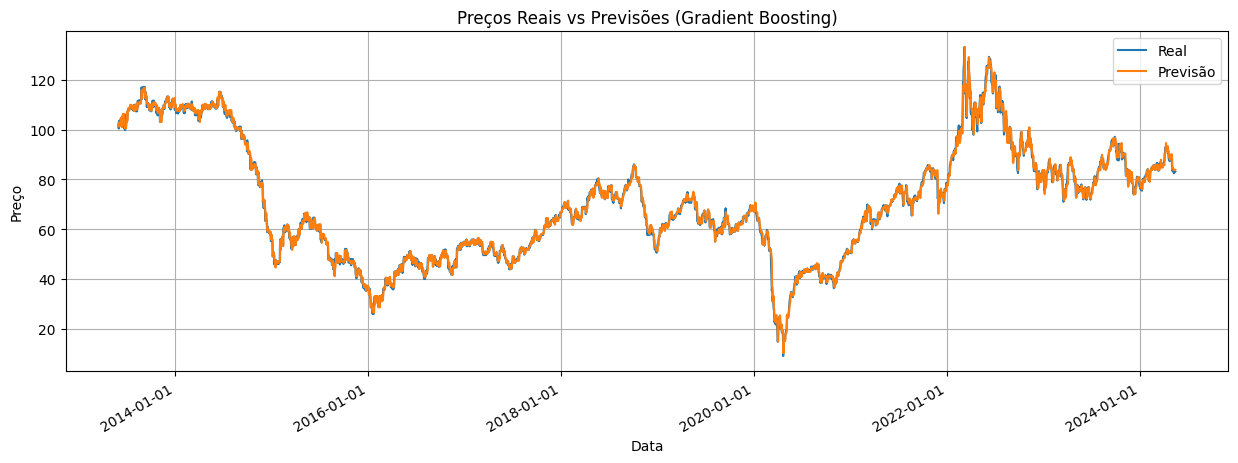

In [23]:
df_gradient =  pd.read_csv('./data/df_ipea.csv')
df_gradient['Data'] = pd.to_datetime(df_gradient['Data'],format='%Y-%m-%d')


# Criação de lag features
for lag in range(1, 3):  # Criar atrasos de 1 dia até 2 dias
    df_gradient[f'Preço_lag_{lag}'] = df_gradient['Preço - petróleo bruto - Brent (FOB)'].shift(lag)

df_gradient = df_gradient.dropna()

# Preparando os dados para treinamento
# X = df_gradient[['Preço_lag_1']].values  # Inputs são os preços atrasados
X = df_gradient[['Preço_lag_1','Preço_lag_2']].values  # Inputs são os preços atrasados
y = df_gradient['Preço - petróleo bruto - Brent (FOB)'].values  # Output é o preço atual

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=42)

# Criar e treinar o modelo de Gradient Boosting
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, loss='squared_error')
model.fit(X_train, y_train)

# Fazer previsões
predictions = model.predict(X_test)
predictions = np.array(predictions).round(2)

# Avaliar o modelo
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print(f"wmape:{wmape(y_test, predictions):.2%}")


# Plot

plt.figure(figsize=(15, 5))
plt.plot(df_gradient['Data'].iloc[-len(y_test):], y_test, label='Real')
plt.plot(df_gradient['Data'].iloc[-len(predictions):], predictions, label='Previsão')

# Formatação do eixo x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formatar as datas como 'Ano-Mês-Dia'
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())             # Escolher automaticamente a localização das datas
plt.gcf().autofmt_xdate()  # Gira as datas para evitar sobreposição

plt.legend()
plt.xlabel('Data')
plt.ylabel('Preço')
plt.grid(True)
plt.title('Preços Reais vs Previsões (Gradient Boosting)')
plt.show()

# Live 09/05/2024 para lag_1
# Mean Squared Error: 2.836992512397856
# Mean Absolute Error: 1.1848350437487067
# Mean wmape:1.68%



In [422]:
# Salvando o modelo
with open('modelo_gradientboosting.pkl','wb') as file:
    pickle.dump(model, file)

In [423]:
# Carregando

with open('modelo_gradientboosting.pkl','rb') as file_2:
    modelo_brent = pickle.load(file_2)
    # df=pickle.load(open('df.p','rb'))

prev = modelo_brent.predict(X_test)

In [37]:
def plot_gradient(df_gradient,lags):

    # Criar recursos de atraso (lag features)
    for lag in range(1, lags + 1):
        df_gradient[f'Preço_lag_{lag}'] = df_gradient['Preço - petróleo bruto - Brent (FOB)'].shift(lag)

    df_gradient = df_gradient.dropna()

    # Preparando os dados para treinamento
    if lags == 2:    
        X = df_gradient[['Preço_lag_1','Preço_lag_2']].values
    elif lags == 3: 
        X = df_gradient[['Preço_lag_1','Preço_lag_2','Preço_lag_3']].values
    elif lags == 4:
        X = df_gradient[['Preço_lag_1','Preço_lag_2','Preço_lag_3','Preço_lag_4']].values
    elif lags == 5:
        X = df_gradient[['Preço_lag_1','Preço_lag_2','Preço_lag_3','Preço_lag_4','Preço_lag_5']].values
    else:
        X = df_gradient[['Preço_lag_1']].values

    y = df_gradient['Preço - petróleo bruto - Brent (FOB)'].values  # Output é o preço atual

    # Dividir os dados em conjuntos de treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

    # Criar e treinar o modelo de Gradient Boosting
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, loss='squared_error')
    model.fit(X_train, y_train)

    # Fazer previsões
    predictions = model.predict(X_test)
    predictions = np.array(predictions).round(2)

    # Avaliar o modelo
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)

    print("Mean Squared Error:", mse)
    print("Mean Absolute Error:", mae)
    print(f"wmape:{wmape(y_test, predictions):.2%}")

    # Fazer previsões para a próxima semana usando os últimos dados conhecidos
    last_known_data = X[-1].reshape(1, -1)
    next_week_predictions = []
    for _ in range(5):  # para cada dia da próxima semana
        next_day_pred = model.predict(last_known_data)[0]
        next_week_predictions.append(next_day_pred)
        last_known_data = np.roll(last_known_data, -1)
        last_known_data[0, -1] = next_day_pred
    next_week_predictions = np.array(next_week_predictions).round(2)

    # As datas correspondentes à próxima semana
    next_week_dates = pd.date_range(df_gradient['Data'].iloc[-1], periods=6,freq='B')[1:]
    next_week_dates = pd.to_datetime(next_week_dates,format='%Y-%m-%d')

    # Selecionar os dados da semana atual (últimos 7 dias do dataset)
    current_week_dates = df_gradient['Data'].iloc[-7:]
    current_week_prices = df_gradient['Preço - petróleo bruto - Brent (FOB)'].iloc[-7:]

    for week, pred in zip(next_week_dates, next_week_predictions):
        print(f'{week}: {pred:.2f}')

    # Plotar os preços reais da semana atual e as previsões para a próxima semana
    plt.figure(figsize=(10, 5))
    plt.plot(current_week_dates, current_week_prices, 'bo-', label='Preços Atuais')
    plt.plot(next_week_dates, next_week_predictions, 'r--o', label='Previsões para a Próxima Semana')


    # Formatação do eixo x
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formatar as datas como 'Ano-Mês-Dia'
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())             # Escolher automaticamente a localização das datas
    plt.gcf().autofmt_xdate()  # Gira as datas para evitar sobreposição
    plt.xlabel('Data')

    plt.ylabel('Preço')
    plt.title('Preços Reais e Previsões para as Últimas Duas Semanas')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

Mean Squared Error: 2.816023200955509
Mean Absolute Error: 1.1843147208121827
wmape:1.68%
2024-05-06 00:00:00: 84.74
2024-05-07 00:00:00: 83.79
2024-05-08 00:00:00: 84.77
2024-05-09 00:00:00: 83.79
2024-05-10 00:00:00: 84.77


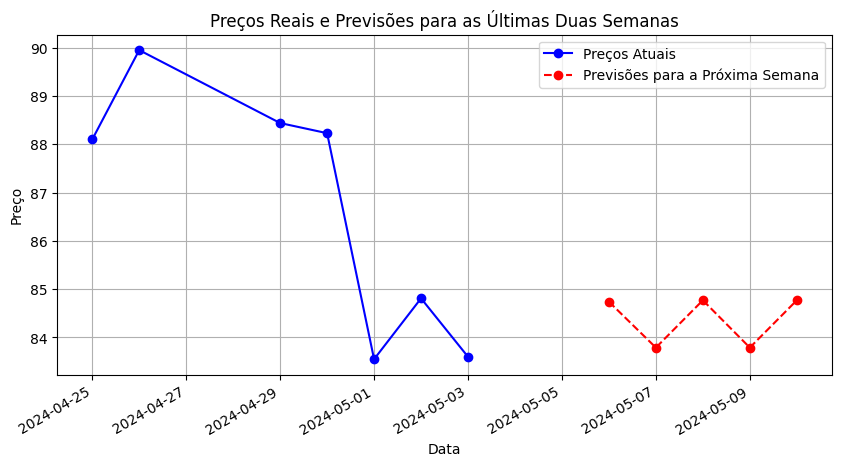

GradientBoostingRegressor(max_depth=5, random_state=42)

In [38]:
# Treino e previsão com dados até 03/05/2024
df_gradient = pd.read_csv('./data/df_ipea.csv')
df_gradient = df_gradient.iloc[:-5,:]
df_gradient['Data'] = pd.to_datetime(df_gradient['Data'],format='%Y-%m-%d')

plot_gradient(df_gradient,2)
# plot_gradient(df_gradient,5)
    # Mean Squared Error: 2.9216809438470728
    # Mean Absolute Error: 1.1871565113500597
    # wmape:1.69%

Comparação com resultados reais de 07/05/2024 a 13/05/2024

In [437]:
# lag 2
mset = mean_squared_error([82.69,82.44,83.27,83.39,83.18],[84.74,83.79,84.77,83.79,84.77])
maet = mean_absolute_error([82.69,82.44,83.27,83.39,83.18],[84.74,83.79,84.77,83.79,84.77])

print("Mean Squared Error:", mset)
print("Mean Absolute Error:", maet)
print(f"Mean wmape:{wmape(np.array([82.69,82.44,83.27,83.39,83.18]),np.array([84.74,83.79,84.77,83.79,84.77])):.2%}")

Mean Squared Error: 2.192619999999996
Mean Absolute Error: 1.3780000000000001
Mean wmape:1.66%


In [ ]:
# # lag 2
# mset = mean_squared_error([82.69,82.44,83.27,83.39], [83.93,83.50,83.82,83.98])
# maet = mean_absolute_error([82.69,82.44,83.27,83.39],  [83.93,83.50,83.82,83.98])

# Mean Squared Error: 0.8279500000000071
# Mean Absolute Error: 0.860000000000003
# Mean wmape:1.04%

In [439]:
# lag 5
mset = mean_squared_error([82.69,82.44,83.27,83.39,83.18],[86.01,85.90,88.50,87.38,89.31])
maet = mean_absolute_error([82.69,82.44,83.27,83.39,83.18],[86.01,85.90,88.50,87.38,89.31])

print("Mean Squared Error:", mset)
print("Mean Absolute Error:", maet)
print(f"Mean wmape:{wmape(np.array([82.69,82.44,83.27,83.39,83.18]),np.array([86.01,85.90,88.50,87.38,89.31])):.2%}")

Mean Squared Error: 20.76878000000001
Mean Absolute Error: 4.426000000000002
Mean wmape:5.33%


lag 5 não ficou bom

Mean Squared Error: 2.8000028648164728
Mean Absolute Error: 1.177893166219039
wmape:1.68%
2024-05-14 00:00:00: 83.86
2024-05-15 00:00:00: 83.83
2024-05-16 00:00:00: 83.82
2024-05-17 00:00:00: 83.82
2024-05-20 00:00:00: 83.82


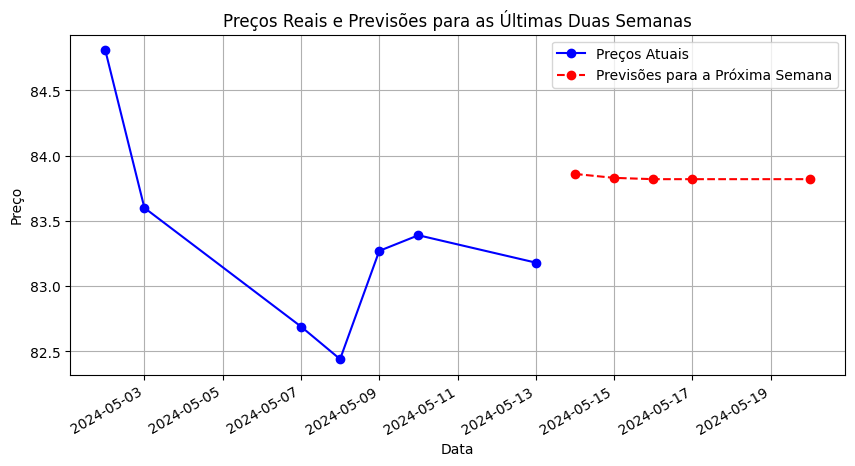

In [24]:
# Treino e previsão com completos para o treinamento
df_gradient = pd.read_csv('./data/df_ipea.csv')
df_gradient['Data'] = pd.to_datetime(df_gradient['Data'],format='%Y-%m-%d')

modelo_gr = plot_gradient(df_gradient,2)
# modelo_gr = plot_gradient(df_gradient,5)
    # Mean Squared Error: 2.938926805970149
    # Mean Absolute Error: 1.1860776119402985
    # wmape:1.69%

In [26]:
# Salvando o modelo
with open('modelo_gradientboosting.pkl','wb') as file:
    pickle.dump(modelo_gr, file)

Com 2 lags features ficou melhor

#### Modelo da biblioteca Prophet

In [6]:
# Treinamento com toda a série histórica
m_full = Prophet()
m_full.add_seasonality(name='weekly', period=2, fourier_order=5)
m_full.fit(treino_full)
future = m_full.make_future_dataframe(periods=5,freq='B')

21:57:59 - cmdstanpy - INFO - Chain [1] start processing
21:58:11 - cmdstanpy - INFO - Chain [1] done processing


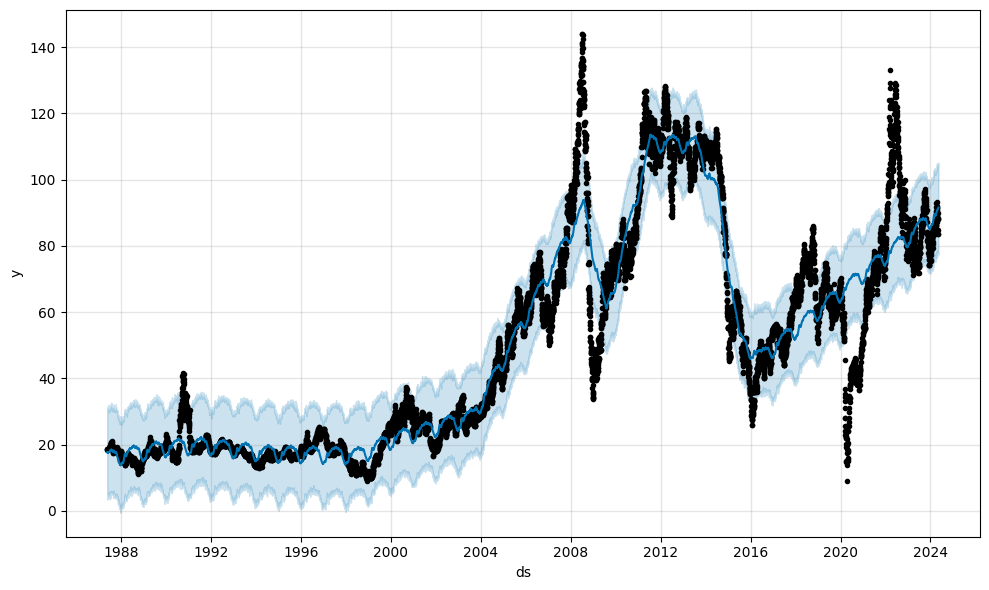

In [7]:
prophet_forecast = m_full.predict(future)
fig = m_full.plot(prophet_forecast)


In [30]:
prophet_future=prophet_forecast.tail(5)
prophet_future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

print(f"WMAPE Prophet: {wmape(teste['y'].values, prophet_future['yhat'].values):.2%}")

mse_p = mean_squared_error(teste['y'], prophet_future['yhat'].values)
mae_p = mean_absolute_error(teste['y'], prophet_future['yhat'].values)
print(f"MSE Prophet: {mse_p}")
print(f"MAE Prophet: {mae_p}")

WMAPE Prophet: 10.17%
MSE Prophet: 71.30961515238357
MAE Prophet: 8.438519237007373


In [31]:
# Treinamento com dados a partir de 2014
m_2014 = Prophet()
m_2014.add_seasonality(name='weekly', period=2, fourier_order=5)
m_2014.fit(treino_2014)
future_2014 = m_2014.make_future_dataframe(periods=5,freq='B')


21:51:55 - cmdstanpy - INFO - Chain [1] start processing
21:51:56 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
prophet_forecast2014 = m_2014.predict(future_2014)
prophet_future2014=prophet_forecast2014.tail(5)
prophet_future2014[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

print(f"WMAPE Prophet: {wmape(teste['y'].values, prophet_future2014['yhat'].values):.2%}")

mse_p = mean_squared_error(teste['y'], prophet_future2014['yhat'].values)
mae_p = mean_absolute_error(teste['y'], prophet_future2014['yhat'].values)
print(f"MSE Prophet: {mse_p}")
print(f"MAE Prophet: {mae_p}")

WMAPE Prophet: 2.61%
MSE Prophet: 4.740505820128795
MAE Prophet: 2.162147790858481


Melhorou muito reduzindo o conjunto de treino

In [33]:
# Treinamento com últimos 60 dias
m_60 = Prophet()
m_60.add_seasonality(name='weekly', period=2, fourier_order=5)
m_60.fit(treino_full.iloc[-60:,:])
future_60 = m_60.make_future_dataframe(periods=5,freq='B')

prophet_forecast60 = m_60.predict(future_60)

prophet_future60=prophet_forecast60.tail(5)
prophet_future60[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

print(f"WMAPE Prophet: {wmape(teste['y'].values, prophet_future60['yhat'].values):.2%}")

mse_p = mean_squared_error(teste['y'], prophet_future60['yhat'].values)
mae_p = mean_absolute_error(teste['y'], prophet_future60['yhat'].values)
print(f"MSE Prophet: {mse_p}")
print(f"MAE Prophet: {mae_p}")

21:51:58 - cmdstanpy - INFO - Chain [1] start processing
21:51:58 - cmdstanpy - INFO - Chain [1] done processing


WMAPE Prophet: 1.38%
MSE Prophet: 1.8262396043390225
MAE Prophet: 1.149230149187747


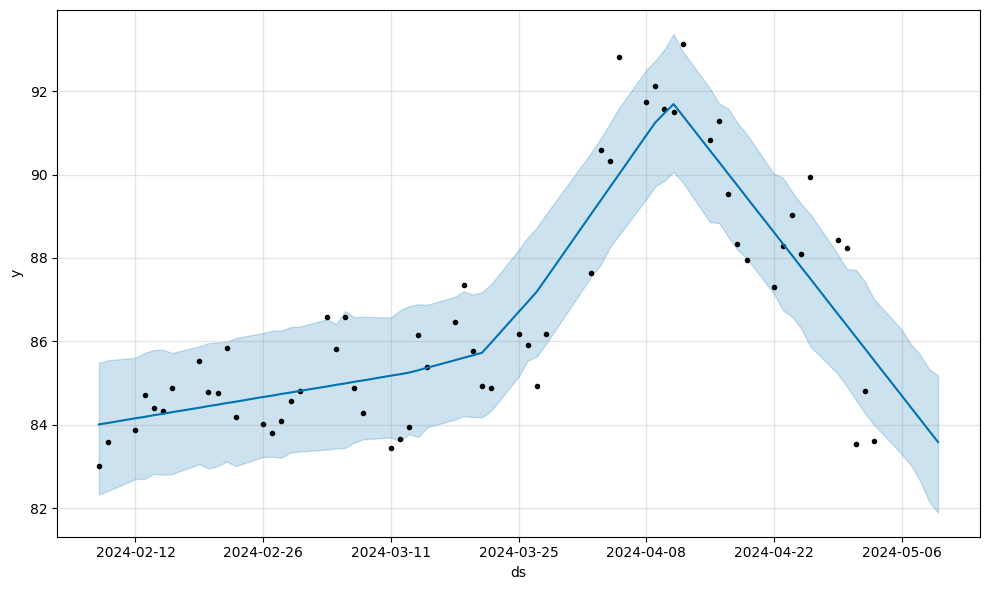

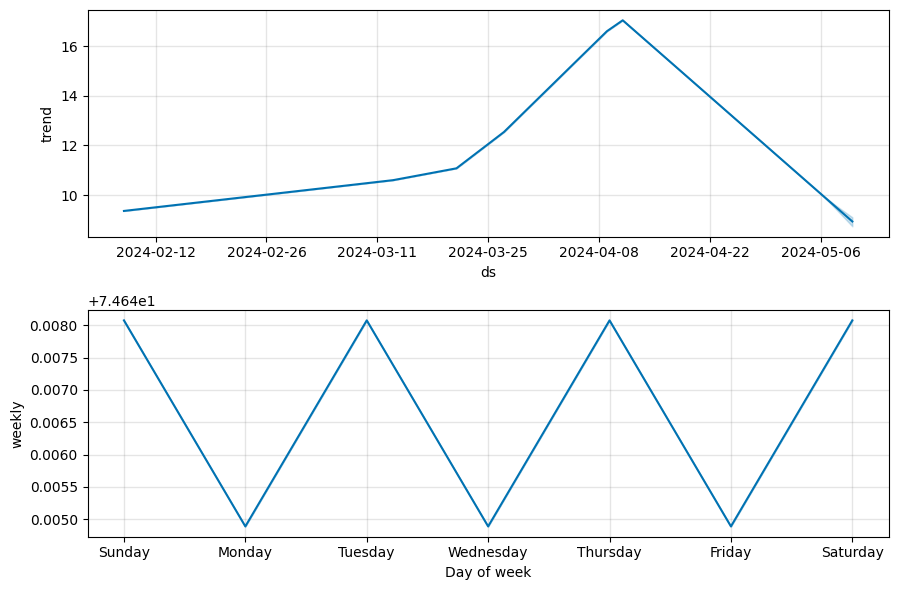

In [34]:
fig = m_60.plot(prophet_forecast60)
fig2 = m_60.plot_components(prophet_forecast60)

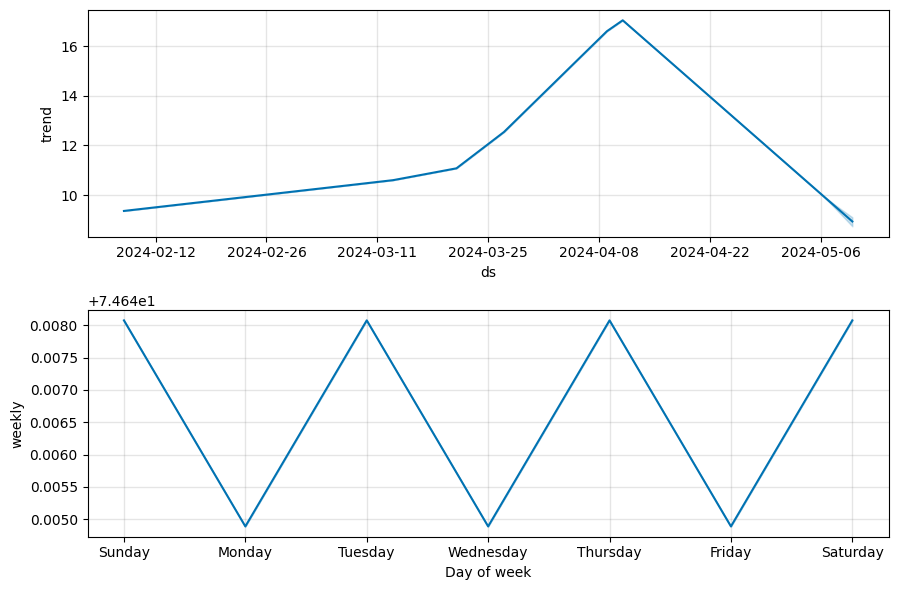

In [37]:
fig2 = m_60.plot_components(prophet_forecast60)

Melhorou mais

In [39]:
# Salvando o modelo
with open('modelo_prophet.pkl','wb') as file:
    pickle.dump(m_60, file)